Trading rules: only long strategy
- inputs
    - Enter rules: momentum signals & TA 
    - Exit rules: dynamic triple exit rule

- outputs
    - outcome of strategy's trading simulation


In [1]:
# lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
plt.style.use('tableau-colorblind10')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize

# homemade
from features import trnd_scan, tautil
from labeling import labeling
from triple_barrier import get_barrier, make_rt
from backtest import print_round_trip_stats, round_trip

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
market_df = pd.read_csv('C:data/market_samsung.csv')
market_df = market_df.rename(columns={market_df.columns[0]:'Date'})
market_df.index = pd.to_datetime(market_df.Date)
market_df.drop(columns='Date',inplace=True)
market_df.dropna(inplace=True)

close = market_df.close['2010':'2020']

# Trading Rules

## Enter rules

### Momentum Prediction

In [4]:
signals = pd.read_csv('C:data/momentum_signals.csv')
signals.index = pd.to_datetime(signals['Date'])
signals.drop(columns='Date',inplace=True)

In [5]:
signals = signals['signals'].loc['2010':'2020']

In [6]:
scaler = normalize
scaler2 = MinMaxScaler()
signals = pd.Series(scaler2.fit_transform(normalize(signals.values.reshape(-1,1),axis=0)).reshape((-1,)), 
                           index=signals.index).rename('signals')

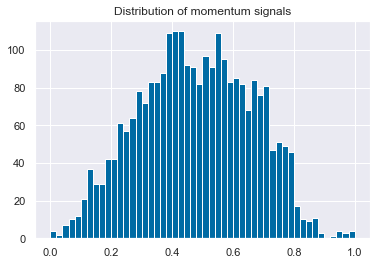

In [7]:
plt.hist(signals,bins=50)[2]
plt.title('Distribution of momentum signals')
plt.show()

In [8]:
thresholds = [0, 0.3]

In [9]:
enter_ml_list=[]
for h in thresholds:
    enter_ml_list.append(signals.loc[signals>h].index)

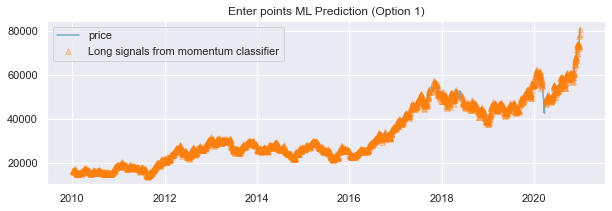

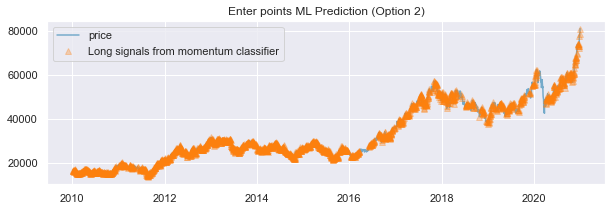

In [10]:
for i in range(len(thresholds)):
    plt.figure(figsize=(10,3))
    plt.plot(close, alpha=0.5)
    plt.title('Enter points ML Prediction (Option {})'.format(i+1))
    plt.plot(close.loc[enter_ml_list[i]],marker='^',linewidth=0,alpha=0.3)
    plt.legend(['price','Long signals from momentum classifier'])
    plt.show()

### Tech. Analysis Long/short decision

In [11]:
open = market_df.open['2010':'2020']
rsi = tautil.RSIIndicator(open,14).rsi().dropna()
long = (rsi>=50) & (rsi<70)
enter_ta = rsi.loc[long].index

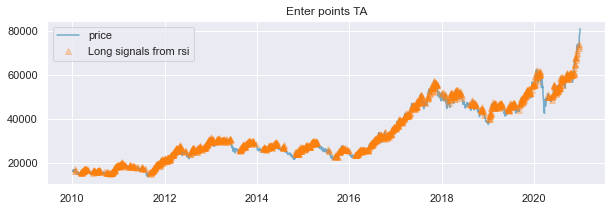

In [12]:
plt.figure(figsize=(10,3))
plt.plot(close, alpha=0.5)
plt.title('Enter points TA')
plt.plot(close.loc[enter_ta],marker='^',linewidth=0,alpha=0.3)
plt.legend(['price','Long signals from rsi'])
plt.show()

In [13]:
enter_list = [enter_ta]
enter_list.append((enter_ml_list[1]& enter_ta).sort_values().drop_duplicates())

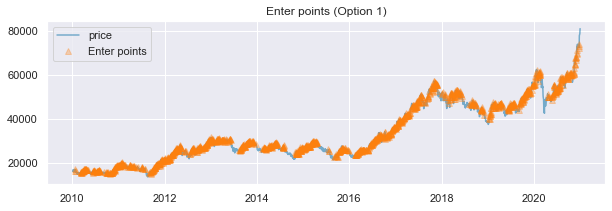

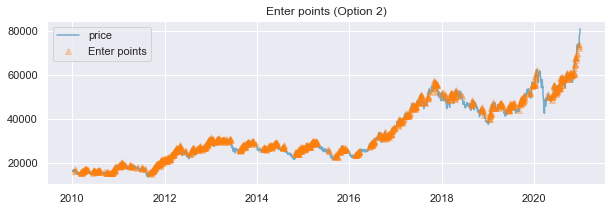

In [14]:
for i in range(len(thresholds)):
    plt.figure(figsize=(10,3))
    plt.plot(close, alpha=0.5)
    plt.title('Enter points (Option {})'.format(i+1))
    plt.plot(close.loc[enter_list[i]],marker='^',linewidth=0,alpha=0.3)
    plt.legend(['price','Enter points'])
    plt.show()

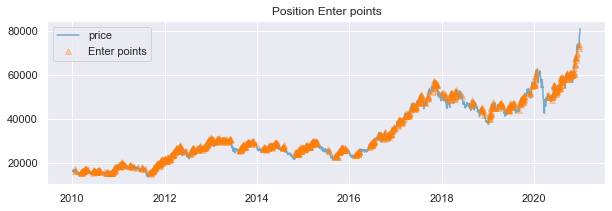

In [15]:
plt.figure(figsize=(10,3))
plt.plot(close, alpha=0.5)
plt.title('Position Enter points'.format(i+1))
plt.plot(close.loc[enter_list[1]],marker='^',linewidth=0,alpha=0.3)
plt.legend(['price','Enter points'])
plt.show()

## Exit rules

In [16]:
# no Rule (benchmark)
pt_sl_bm = [1000,1000]
max_holding_bm = [1, 0]
no_exit_rule = [pt_sl_bm,max_holding_bm]

In [17]:
#dynamic target rule
max_holding = [60, 0]
close_ = market_df.close['2009':'2020']
changes = close_.pct_change(1).to_frame()
for i in range(2,max_holding[0]+1):
    changes = changes.join(close_.pct_change(i).rename('close {}'.format(i)))
dynamic_target = changes.abs().dropna().mean(axis=1)['2010':]

In [22]:
barrier_exit_list=[]
barrier_exit_list.append(get_barrier(close, enter_list[1], [1,1], max_holding, target = dynamic_target))  #dynamic  

rts_exit_list=[]
for i in range(len(barrier_exit_list)):
    rts_exit_list.append(make_rt(close,barrier_exit_list[i].dropna()))

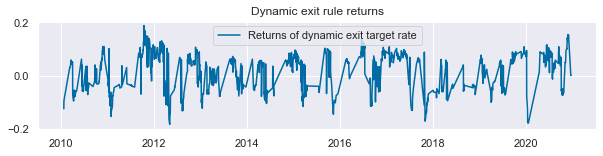

In [26]:
plt.figure(figsize=(10,2))
plt.title('Dynamic exit rule returns')
plt.plot(barrier_exit_list[0].ret)
plt.legend(['Returns of dynamic exit target rate'])

# Results
## Benchmarks

In [27]:
barrier_bm = get_barrier(close, close.index, no_exit_rule[0], no_exit_rule[1]) #no rule

In [28]:
rts_bm = make_rt(close,barrier_bm.dropna())

In [29]:
round_trip.get_df_ann_sr(rts_bm,'Benchmark',years=11)

,Benchmark
avg_n_bets_per_year,243.272727
win_ratio,0.518835
annualized_sharpe_ratio,0.537080


In [30]:
result_df = pd.concat([round_trip.get_df_ann_sr(rts_bm,'No Rule')], axis=1)
for i in range(len(rts_exit_list)):
    result_df = result_df.join(round_trip.get_df_ann_sr(rts_exit_list[i],'Enter & Exit Rule'))
    
result_df

,No Rule,Enter & Exit Rule
avg_n_bets_per_year,243.272727,105.000000
win_ratio,0.518835,0.590988
annualized_sharpe_ratio,0.537080,1.800316


In [31]:
#dynamic target rule
# different maximum holding
close_ = market_df.close['2009':'2020']
rolling = np.arange(20,260,10)
mhs = [20,60,120,260]
win_ratios = pd.DataFrame()

for mh in mhs:
    max_holding = [mh, 0]
    dynamic_targets = []
    for j in rolling:
        for i in range(2,j+1):
            changes = close_.pct_change(1).to_frame()
            changes = changes.join(close_.pct_change(i).rename('close {}'.format(i)))
        dynamic_target = changes.abs().dropna().mean(axis=1)['2010':]
        dynamic_targets.append(dynamic_target)

    barrier_exit_list_rolling=[]
    for i in range(len(dynamic_targets)):
        barrier_exit_list_rolling.append(get_barrier(close, enter_list[1], [1,1], max_holding, target = dynamic_targets[i]))  #dynamic  

    rts_exit_list=[]
    for i in range(len(barrier_exit_list_rolling)):
        rts_exit_list.append(make_rt(close,barrier_exit_list_rolling[i].dropna()))

    result_df = pd.concat([round_trip.get_df_ann_sr(rts_bm,'No Rule')], axis=1)
    for i in range(len(rts_exit_list)):
        result_df = result_df.join(round_trip.get_df_ann_sr(rts_exit_list[i],'{}'.format(rolling[i])))

    win_ratios['Max. holding {} days'.format(mh)] = result_df.T.win_ratio
win_ratios

,Max. holding 20 days,Max. holding 60 days,Max. holding 120 days,Max. holding 260 days
No Rule,0.518835,0.518835,0.518835,0.518835
20,0.541054,0.576857,0.572169,0.575130
30,0.564014,0.573898,0.570069,0.570441
40,0.532872,0.559689,0.553155,0.550562
50,0.555363,0.588591,0.589455,0.587727
60,0.564991,0.605195,0.605195,0.603463
70,0.562392,0.605195,0.600866,0.595671
80,0.557192,0.600000,0.584416,0.586147
90,0.555459,0.599134,0.598787,0.601732
100,0.563258,0.587522,0.600520,0.599653


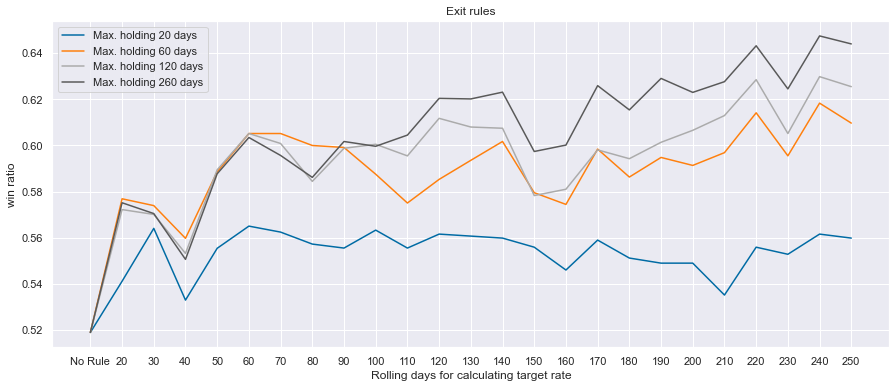

In [32]:
plt.figure(figsize=(15,6))
plt.title("Exit rules")
plt.plot(win_ratios)
plt.legend(win_ratios)
plt.ylabel('win ratio')
plt.xlabel('Rolling days for calculating target rate')
plt.show()

# For next research

In [33]:
barrier = get_barrier(close, enter_list[1], [1,1], max_holding, target = dynamic_target)
rts = make_rt(close,barrier.dropna())

In [34]:
round_trip.get_df_ann_sr(rts,'Chose for 2nd model')

,Chose for 2nd model
avg_n_bets_per_year,104.818182
win_ratio,0.644097
annualized_sharpe_ratio,3.122372


In [35]:
print_round_trip_stats(rts)

Summary stats,All trades,Long trades
Total number of round_trips,1153.00,1153.00
Percent profitable,0.64,0.64
Winning round_trips,742.00,742.00
Losing round_trips,410.00,410.00
Even round_trips,1.00,1.00


PnL stats,All trades,Long trades
Total profit,$1562060.00,$1562060.00
Gross profit,$2900830.00,$2900830.00
Gross loss,$-1338770.00,$-1338770.00
Profit factor,$2.17,$2.17
Avg. trade net profit,$1354.78,$1354.78
Avg. winning trade,$3909.47,$3909.47
Avg. losing trade,$-3265.29,$-3265.29
Ratio Avg. Win:Avg. Loss,$1.20,$1.20
Largest winning trade,$15720.00,$15720.00
Largest losing trade,$-19350.00,$-19350.00


Duration stats,All trades,Long trades
Avg duration,98 days 20:41:25.342584562,98 days 20:41:25.342584562
Median duration,51 days 00:00:00,51 days 00:00:00
Longest duration,264 days 00:00:00,264 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.22%,0.22%
Avg returns winning,1.38%,1.38%
Avg returns losing,-1.22%,-1.22%
Median returns all round_trips,0.18%,0.18%
Median returns winning,1.06%,1.06%
Median returns losing,-0.99%,-0.99%
Largest winning trade,8.69%,8.69%
Largest losing trade,-9.44%,-9.44%


Symbol stats,Asset
Avg returns all round_trips,0.22%
Avg returns winning,1.38%
Avg returns losing,-1.22%
Median returns all round_trips,0.18%
Median returns winning,1.06%
Median returns losing,-0.99%
Largest winning trade,8.69%
Largest losing trade,-9.44%


In [36]:
barrier.to_csv('C:data/barrier.csv')

In [37]:
barrier_bm.to_csv('C:data/barrier_bm.csv')